In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as datetime
import warnings

from sklearn.multiclass import OneVsOneClassifier
from dateutil.parser import parse
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import Perceptron,RidgeClassifier,LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

warnings.filterwarnings('ignore')

In [2]:
AP = pd.read_csv('AP.csv')
AP = AP.iloc[:,1:]
AP.head()

,ORIG_RT,ORIG_AMT,ORIG_TRM,FRST_DTE,OLTV,OCLTV,NUM_BO,DTI,CSCORE_B,FTHB_FLG,...,OCC_STAT_I,OCC_STAT_P,OCC_STAT_S,ZeroBalCode_0.0,ZeroBalCode_1.0,ZeroBalCode_2.0,ZeroBalCode_3.0,ZeroBalCode_6.0,ZeroBalCode_9.0,ZeroBalCode_15.0
0,8.000,75000,360,396,79.0,80.0,1.0,62.0,763.0,0,...,0,1,0,1,0,0,0,0,0,0
1,7.875,55000,180,425,69.0,80.0,1.0,12.0,633.0,0,...,0,1,0,0,1,0,0,0,0,0
2,7.750,123000,360,365,80.0,80.0,1.0,28.0,750.0,0,...,0,1,0,1,0,0,0,0,0,0
3,8.500,51000,360,456,95.0,80.0,1.0,27.0,686.0,0,...,0,1,0,1,0,0,0,0,0,0
4,8.750,242000,360,456,95.0,80.0,1.0,47.0,706.0,0,...,0,1,0,0,1,0,0,0,0,0


In [3]:
AP['Normal'] = AP['ZeroBalCode_0.0']
AP['Default'] = AP['ZeroBalCode_1.0'] + AP['ZeroBalCode_6.0']
AP['Prepaid'] = AP['ZeroBalCode_2.0'] + AP['ZeroBalCode_3.0'] + AP['ZeroBalCode_9.0'] + AP['ZeroBalCode_15.0']
ZBC = ['ZeroBalCode_0.0','ZeroBalCode_1.0', 'ZeroBalCode_2.0', 'ZeroBalCode_3.0', 'ZeroBalCode_6.0',
       'ZeroBalCode_9.0', 'ZeroBalCode_15.0']
AP = AP.drop(ZBC,axis=1)
AP['ZeroBalCode'] = AP.iloc[:,-3:].values.argmax(axis=1)

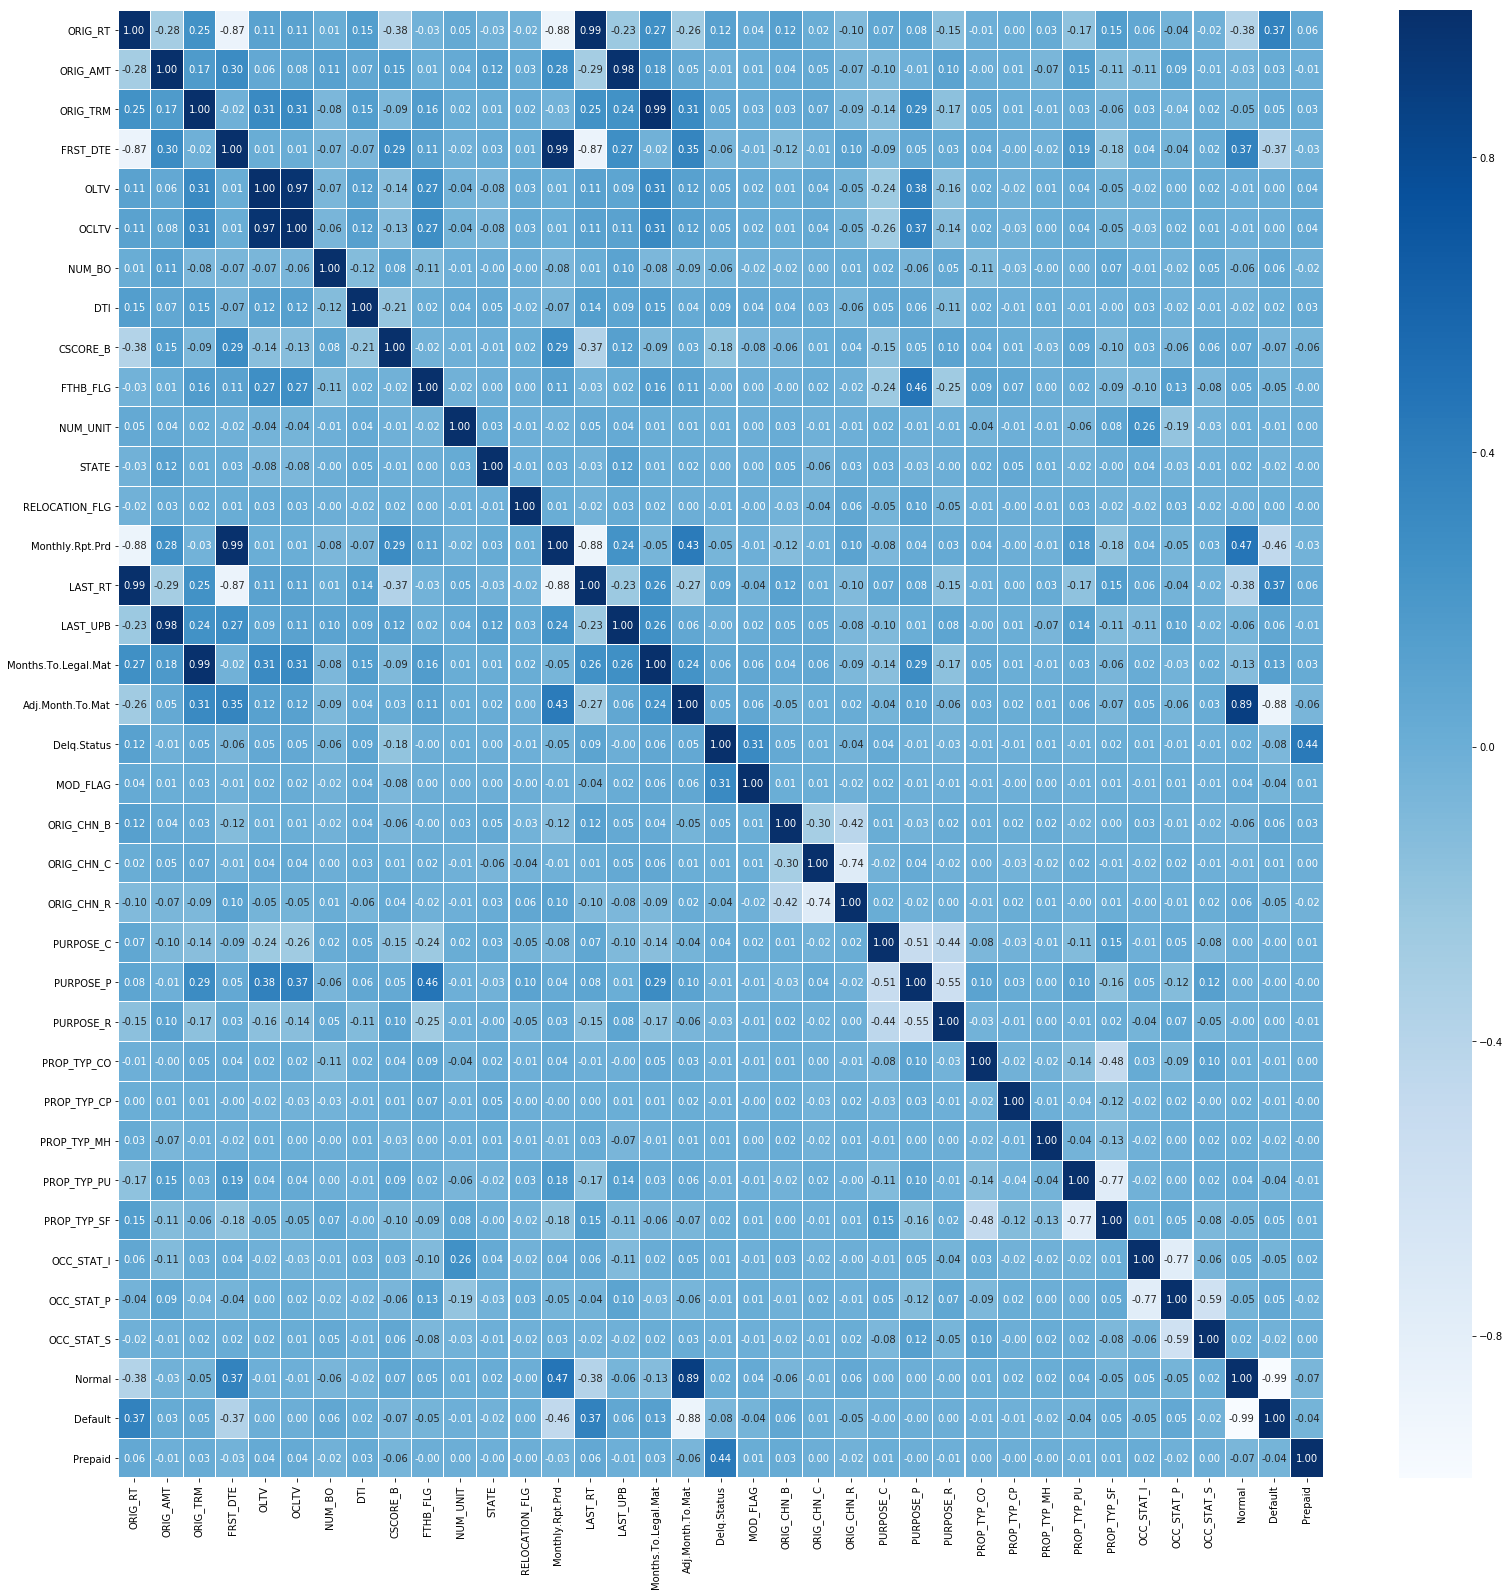

In [4]:
fig,ax = plt.subplots(figsize=(27,27))
sns.heatmap(AP.iloc[:,:-1].corr(),annot=True,linewidths=.1,fmt= '.2f',ax=ax,cmap=plt.cm.Blues)
plt.show()
fig.savefig('hmap.jpg')

In [5]:
x_classification = AP.drop('Delq.Status',axis=1)
x_classification = x_classification.iloc[:,:-4]
y_classification = AP.iloc[:,-1]

In [6]:
num = np.sum(y_classification.values == 2)
num0 = np.where(y_classification == 0)[0][:num]
num1 = np.where(y_classification == 1)[0][:num]
num2 = np.where(y_classification == 2)
sample = np.vstack([num0,num1,num2]).ravel()

In [7]:
x_classification = x_classification.values[sample,:]
y_classification = y_classification[sample]

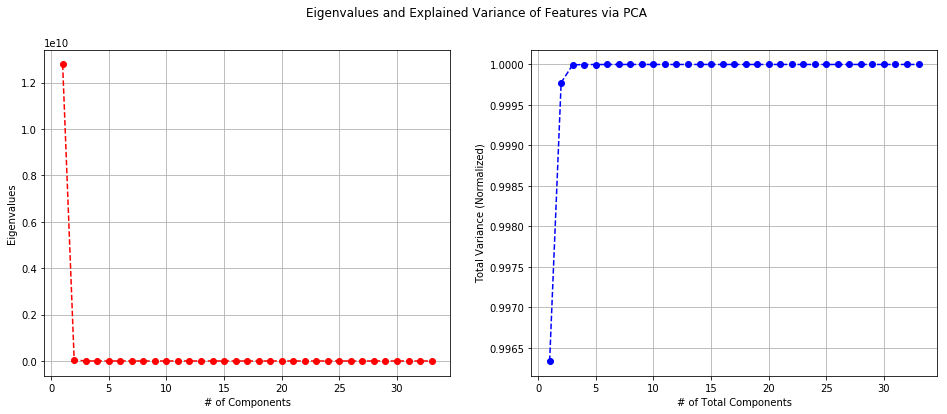

In [8]:
pca = PCA(n_components=x_classification.shape[1], whiten=True)
B = pca.fit_transform(x_classification)
L = pca.explained_variance_

fig = plt.figure(figsize=(16,6))
plt.suptitle('Eigenvalues and Explained Variance of Features via PCA')

plt.subplot(121)
plt.plot(np.arange(x_classification.shape[1]) + 1,L,'o--r')
plt.xlabel('# of Components')
plt.ylabel('Eigenvalues')
plt.grid(True)

plt.subplot(122)
var = np.cumsum(L) / np.sum(L)
plt.xlabel('# of Total Components')
plt.ylabel('Total Variance (Normalized)')
plt.plot(np.arange(x_classification.shape[1]) + 1,var,'o--b')
plt.grid(True)
plt.show()

In [9]:
x_classification_new = B[:,:2]
x_train, x_test, y_train, y_test = train_test_split(x_classification_new, y_classification,test_size=0.4)

In [10]:
models = []
models.append(('Perceptron',OneVsOneClassifier(Perceptron())))
models.append(('Ridge Classiier',OneVsOneClassifier(RidgeClassifier())))
models.append(('Logistic Regression',OneVsOneClassifier(LogisticRegression())))
models.append(('KNN Classifier',OneVsOneClassifier(KNeighborsClassifier())))
models.append(('Linear SVM Classifier',OneVsOneClassifier(LinearSVC())))
models.append(('RBF SVM Classifier',OneVsOneClassifier(SVC())))
models.append(('Random Forest Classifier',OneVsOneClassifier(RandomForestClassifier())))
models.append(('Naive Bayes Classifier',OneVsOneClassifier(GaussianNB())))

In [11]:
model_results = []
model_names = []
for name, model in models:
    kfold = KFold(n_splits=10)
    cv_result = cross_val_score(model,x_train,y_train,cv=kfold)
    model_results.append(cv_result+0.1)
    model_names.append(name)

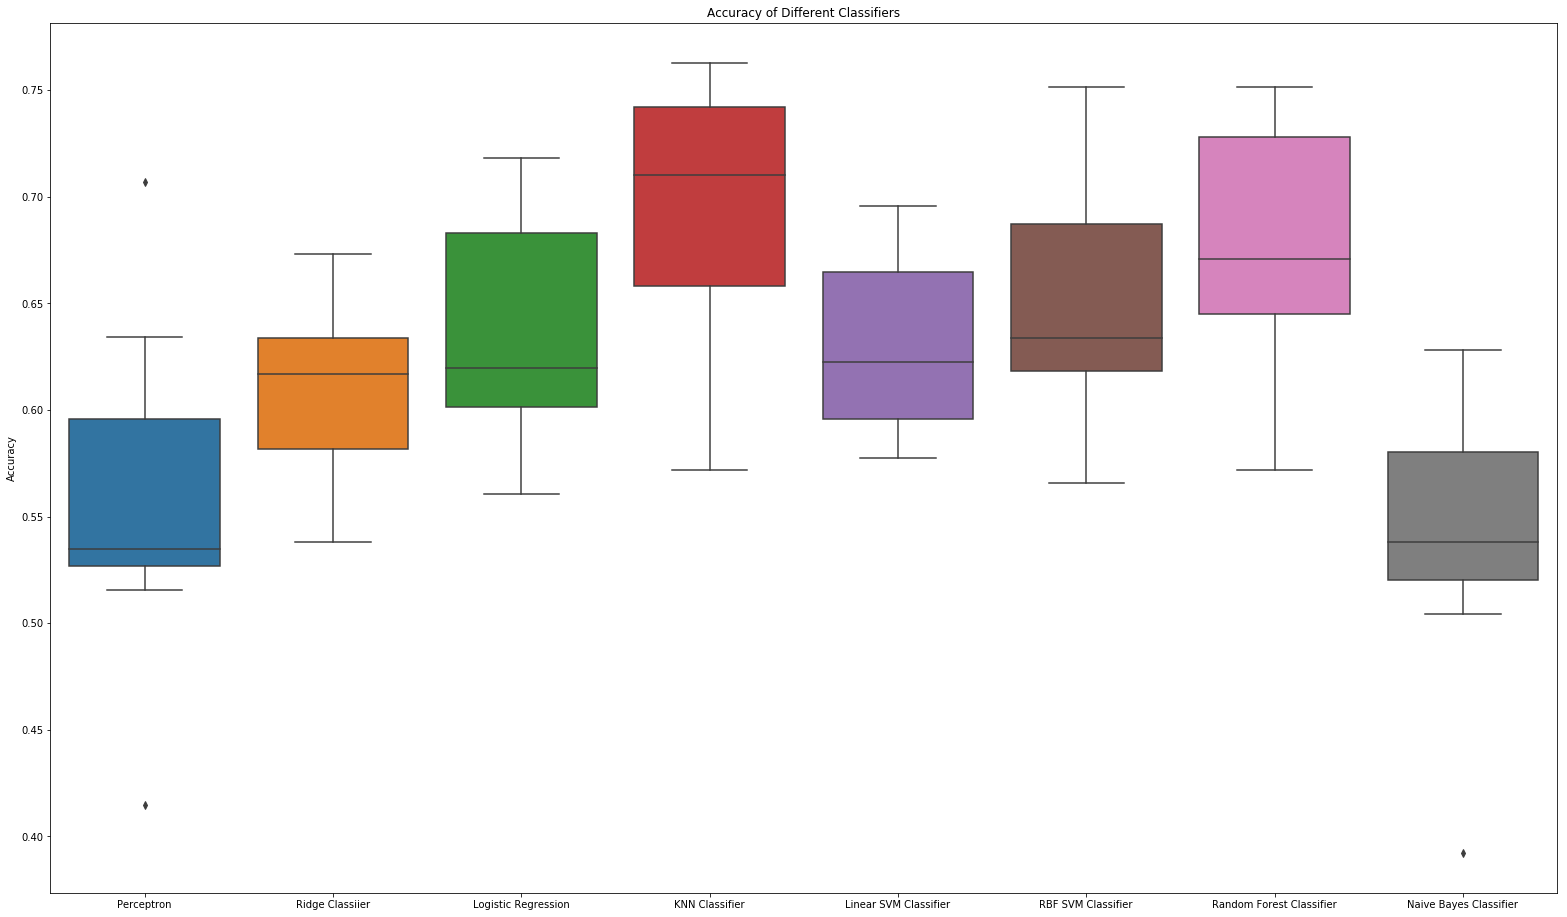

In [12]:
fig = plt.figure(figsize=(27,16))
sns.boxplot(x=model_names,y=model_results)
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Classifiers')
plt.show()
fig.savefig('classifiers.jpg')

In [13]:
KNN = OneVsOneClassifier(KNeighborsClassifier())
fit = KNN.fit(x_train,y_train)
pred = KNN.predict(x_classification_new)

In [14]:
cm = confusion_matrix(y_classification,pred)
cm = cm / cm.sum(1)
status = ['Normal','Default','Prepaid']
df = pd.DataFrame(cm,index=status,columns=status)
df.columns.name = 'Predicted Status'
df.index.name = 'Actual Status'
df

Predicted Status,Normal,Default,Prepaid
Actual Status,,,
Normal,0.821501,0.146045,0.032454
Default,0.215010,0.543611,0.241379
Prepaid,0.117647,0.255578,0.626775
